# Lab Work #1
### Nedozhdii Oleksii FF-31mn

 1) Завантажити дані, вивести назви колонок і розмір датасета
 2) Опрацювати пропуски (по можливості заповнити їх або видалити)
 3) Візуалізувати дані: побудувати графік (heatmap), що відображає кореляції
 ознак між собою і з цільовою змінною (розміткою); побудувати гістограми
 розподілу ознак і boxplot-и ознак відносно цільової змінної (якщо ознак занадто багато
 обмежитися декількома)
 4) Нормалізувати дані
 5) Провести навчання наступних класифікаторів:
 - kNN
 - дерево ухвалення рішень
 - SVM
 - Random Forest
 - AdaBoost

 Підібрати оптимальні параметри
 - для kNN
 - для SVM за допомогою GridSearch підібрати оптимальні `C` і `gamma`
 - Серед обраних оптимальних моделей кожного класу вибрати найкращу.
 - Відобразити
 sklearn.metrics.classification_report і sklearn.metrics.confusion_matrix

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV


plt.style.use("default")

### Preate data

In [2]:
df = pd.read_csv("OnlineNewsPopularity/OnlineNewsPopularity.csv",
                 skipinitialspace=True)

# it's not fair to compare shares number for 8 and 30 days articles
# drop not useful(for now) data
df["shares_per_day"] = df["shares"] / df["timedelta"]
df = df.drop(columns=["url", "timedelta", "shares",
                      "is_weekend", "LDA_00", "LDA_01",
                      "LDA_02", "LDA_03", "LDA_04"])

# choose target and features
targets=[
    "data_channel_is_lifestyle",
    "data_channel_is_entertainment",
    "data_channel_is_bus",
    "data_channel_is_socmed",
    "data_channel_is_tech",
    "data_channel_is_world",
]
features = df.columns.drop(labels=targets)

# delete rows without target values
df = df[df[targets].any(axis=1)]

# check and drop null valus
null_indexes = sum(np.nonzero(pd.isnull(df)))
if len(null_indexes) > 0:
    print("Ups, spot null value. Going to drop it.")
    df = df.dropna()

# multiple columns data_channel_is_* -> one column with multiple values
labels = dict(zip(targets, ["Lifestyle", "Entertainment", "Business", "Social Media", "Tech", "World"]))
df["data_channel"] = df.apply(lambda row: [col for col in df.columns if row[col] and col.startswith("data_channel_")][0], axis=1)
for key in labels.keys():
    df.loc[df["data_channel"] == key, "data_channel"] = labels[key]
df = df.drop(columns=[col for col in df.columns if col.startswith("data_channel_is")])
del targets

### Present data

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 33510 entries, 0 to 39643
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n_tokens_title                33510 non-null  float64
 1   n_tokens_content              33510 non-null  float64
 2   n_unique_tokens               33510 non-null  float64
 3   n_non_stop_words              33510 non-null  float64
 4   n_non_stop_unique_tokens      33510 non-null  float64
 5   num_hrefs                     33510 non-null  float64
 6   num_self_hrefs                33510 non-null  float64
 7   num_imgs                      33510 non-null  float64
 8   num_videos                    33510 non-null  float64
 9   average_token_length          33510 non-null  float64
 10  num_keywords                  33510 non-null  float64
 11  kw_min_min                    33510 non-null  float64
 12  kw_max_min                    33510 non-null  float64
 13  kw_avg

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares_per_day
count,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000,...,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000
mean,10.416204,585.438317,0.549702,1.015010,0.699134,10.380603,3.368517,3.959445,0.998448,4.607736,...,0.091221,0.762561,-0.255202,-0.524040,-0.104041,0.265740,0.068661,0.343692,0.145570,16.987959
std,2.134557,483.838530,3.828350,5.688218,3.549460,10.599809,3.883522,7.725860,3.651955,0.646702,...,0.064398,0.231811,0.117386,0.283454,0.086693,0.314245,0.252802,0.188397,0.217789,64.876236
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.002532
25%,9.000000,272.000000,0.467396,1.000000,0.628370,4.000000,1.000000,1.000000,0.000000,4.490385,...,0.050000,0.600000,-0.318403,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,2.572347
50%,10.000000,447.000000,0.532596,1.000000,0.690411,7.000000,3.000000,1.000000,0.000000,4.669471,...,0.100000,0.800000,-0.250000,-0.500000,-0.100000,0.100000,0.000000,0.500000,0.000000,5.371901
75%,12.000000,761.000000,0.600000,1.000000,0.752475,13.000000,4.000000,3.000000,1.000000,4.852841,...,0.100000,1.000000,-0.186667,-0.300000,-0.050000,0.500000,0.136364,0.500000,0.225000,12.941176
max,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,75.000000,7.695652,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,3697.402597


### Features and target

In [4]:
target = "data_channel"
features = df.columns.drop(labels=target).to_list()
target_values = df["data_channel"].unique()

### Calculate correlation matrix

In [5]:
le = LabelEncoder()
df_encoded = df.copy()
df_encoded[target] = le.fit_transform(df[target])
corr_matrix = df_encoded.corr()

### Heatmap All

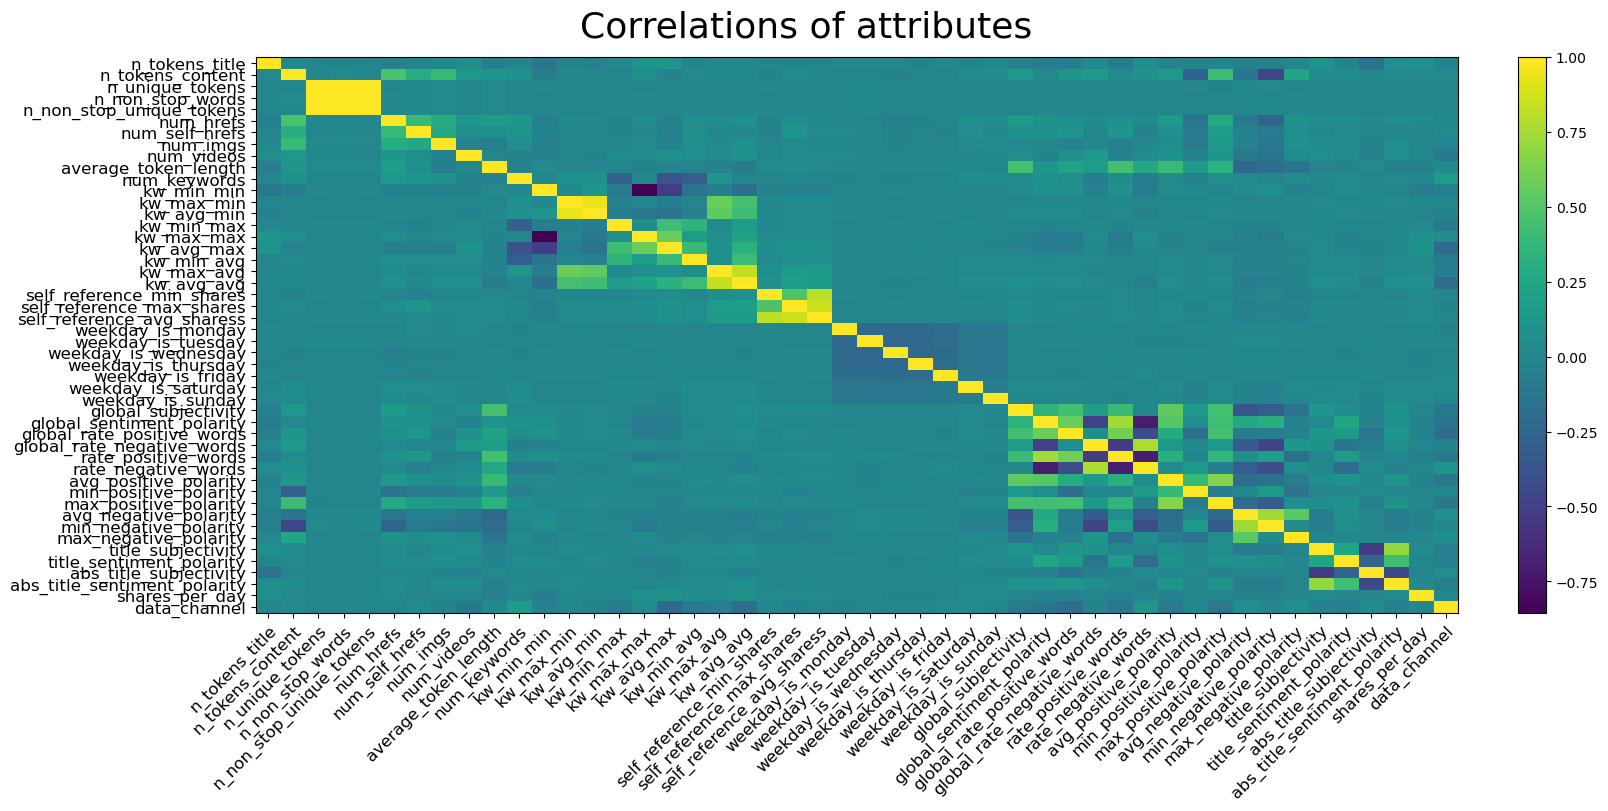

In [6]:
fig, ax = plt.subplots(layout="constrained", figsize=(16, 8))
fig.suptitle("Correlations of attributes", fontsize=26)
im = ax.imshow(corr_matrix, aspect="auto")
ax.set_xticks(np.arange(len(corr_matrix.columns)), labels=corr_matrix.columns, fontsize=12)
ax.set_yticks(np.arange(len(corr_matrix.index)), labels=corr_matrix.index, fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.colorbar(im);

### Heatmap wiht correlations more than 0.7

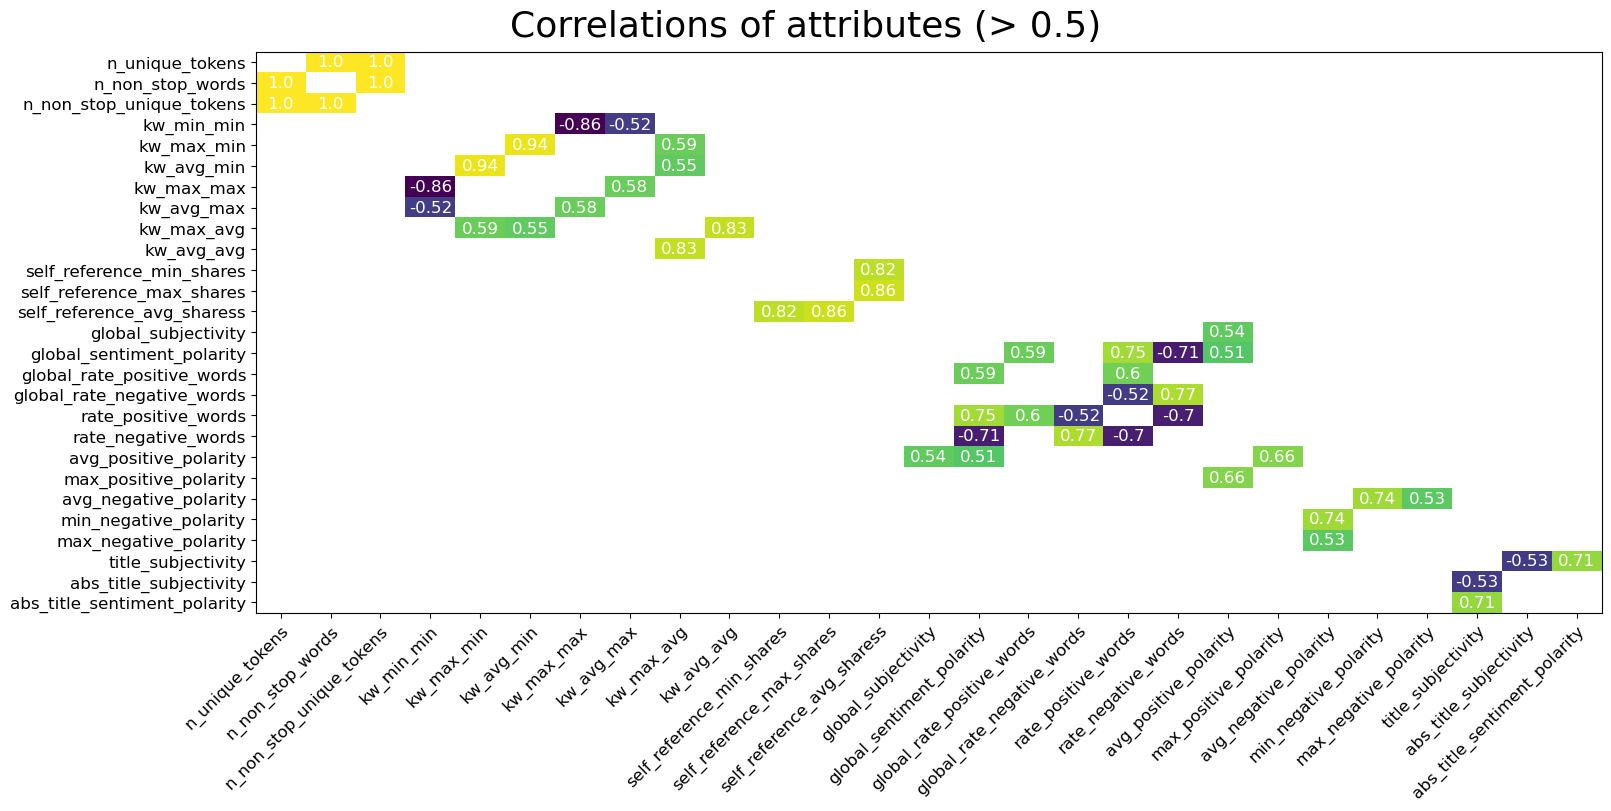

In [7]:
threshold = 0.5
corr_matrix_trheshold = corr_matrix[abs(corr_matrix) >= threshold]
corr_matrix_trheshold = corr_matrix_trheshold[abs(corr_matrix) != 1.0]
corr_matrix_trheshold = corr_matrix_trheshold.dropna(axis=1, how='all')
corr_matrix_trheshold = corr_matrix_trheshold.dropna(axis=0, how='all')
fig, ax = plt.subplots(layout="constrained", figsize=(16, 8))
fig.suptitle(f"Correlations of attributes (> {threshold})", fontsize=26)

im = ax.imshow(corr_matrix_trheshold, aspect="auto")
ax.set_xticks(np.arange(len(corr_matrix_trheshold.columns)), labels=corr_matrix_trheshold.columns, fontsize=12)
ax.set_yticks(np.arange(len(corr_matrix_trheshold.index)), labels=corr_matrix_trheshold.index, fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(corr_matrix_trheshold.shape[0]):
    for j in range(corr_matrix_trheshold.shape[1]):
        text = ax.text(j, i, round(corr_matrix_trheshold.iloc[i, j], 2),
                       ha="center", va="center", color="w", fontsize=12,)

### Select most valuabale features

In [8]:
corr_target = corr_matrix.loc[target]
corr_target = corr_target.drop("data_channel")
N = 3
corr_target_largest = corr_target.nlargest(N)
print(corr_target_largest)

num_keywords             0.163220
rate_negative_words      0.109826
avg_negative_polarity    0.076170
Name: data_channel, dtype: float64


### Features Distribution

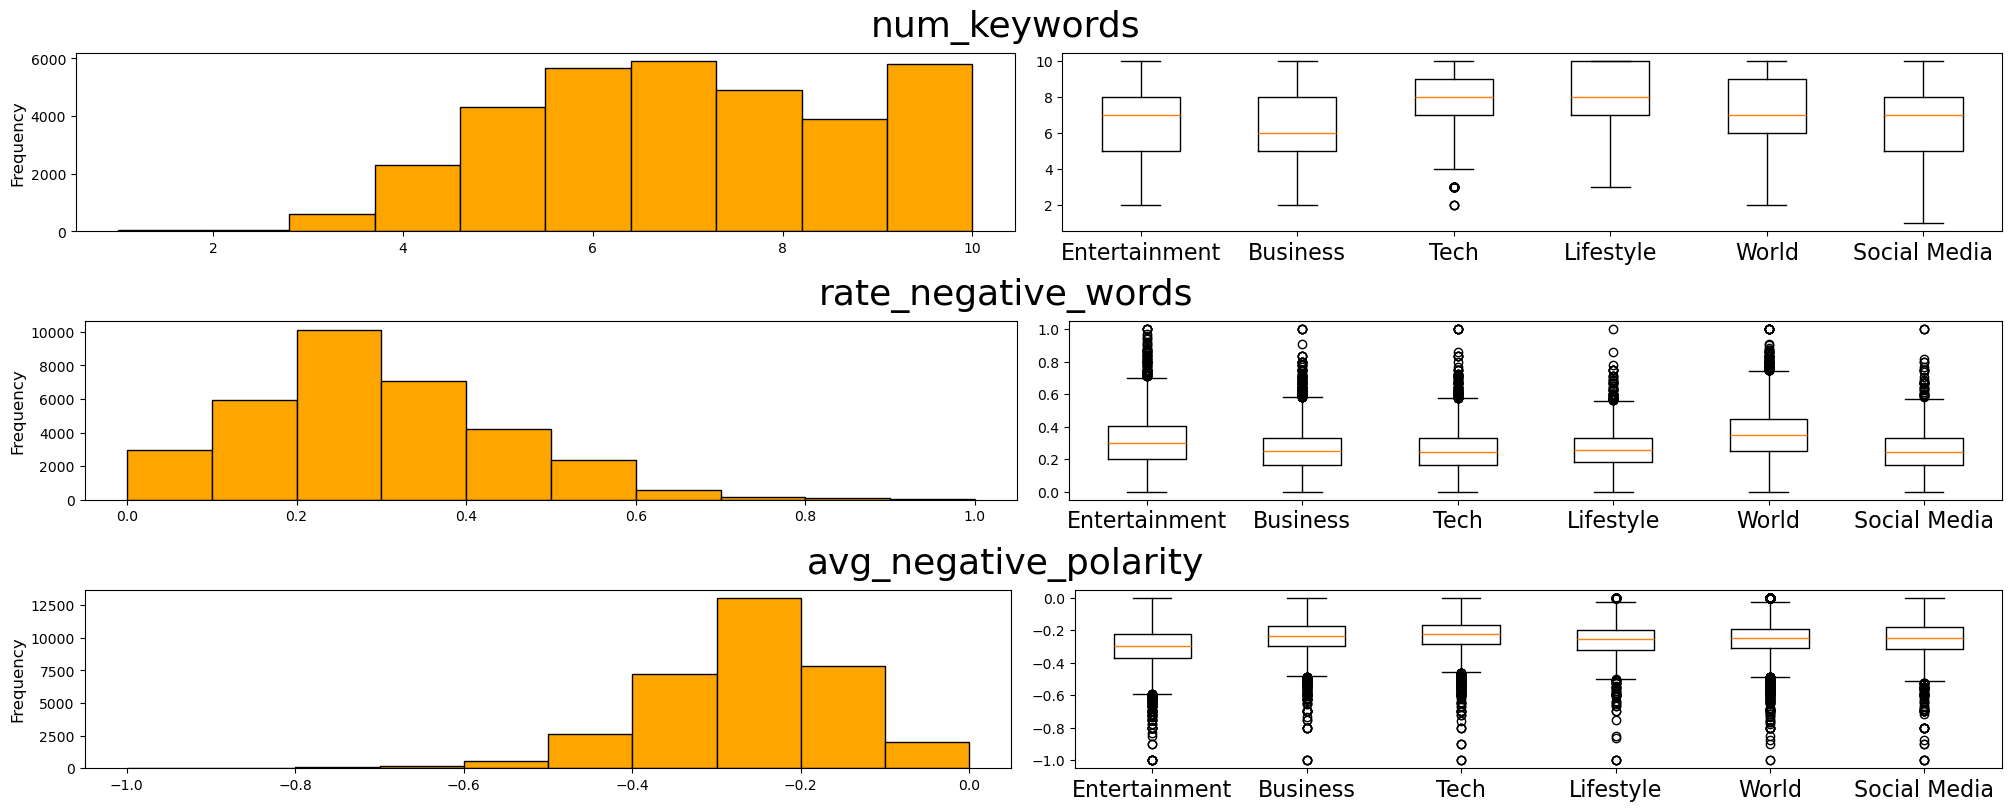

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(20, 8))
subfigs = fig.subfigures(nrows=N, ncols=1)
for subfig, feature in zip(subfigs, corr_target_largest.index):
    subfig.suptitle(f"{feature}", fontsize=26)
    axis = subfig.subplots(nrows=1, ncols=2)
    df.hist(column=feature, ax=axis[0], color="orange", edgecolor="black", grid=False)
    axis[0].set_title("")
    axis[0].set_ylabel("Frequency", fontsize=12)
    axis[1].boxplot([df.query(f"{target} == \"{t}\"")[feature] for t in target_values])
    axis[1].set_xticks(np.arange(1, len(target_values) + 1), labels=target_values, fontsize=16)
plt.show()

### Function to fit preconfigured model and score it

In [10]:
def fit_and_score(model):
    model.fit(X=X_train, y=y_train)
    y_pred = model.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred, normalize="all")
    accuracies = map(lambda x: round(x, 2), np.diag(conf_matrix) / np.sum(conf_matrix, axis=1))
    accuracy_table = pd.DataFrame({'Class': model.classes_, 'Accuracy': accuracies})
    table_data = accuracy_table.values

    fig, ax = plt.subplots(layout="constrained", figsize=(16, 8))
    conf_matrix_plot = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                           display_labels=model.classes_)
    conf_matrix_plot.plot(ax=ax, colorbar=False)
    table_plot = ax.table(cellText=table_data,
                      colLabels=['Class', 'Accuracy'],
                      cellLoc='center', bbox=[0.1, -0.3, 0.8, 0.2])
    table_plot.auto_set_font_size(False)
    table_plot.set_fontsize(10)
    # print(conf_matrix)
    print(classification_report(y_test, y_pred))

### Normalize data

In [11]:
scaler = MinMaxScaler()
features_norm = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

### Split dataset into train and test sets

In [22]:
X, y = features_norm, df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train: {y_train.value_counts()}")
print(f"Test: {y.value_counts()}")

Train: data_channel
World            6736
Tech             5851
Entertainment    5615
Business         5048
Social Media     1861
Lifestyle        1697
Name: count, dtype: int64
Test: data_channel
World            8427
Tech             7346
Entertainment    7057
Business         6258
Social Media     2323
Lifestyle        2099
Name: count, dtype: int64


### KNN

               precision    recall  f1-score   support

     Business       0.43      0.42      0.43      1210
Entertainment       0.54      0.33      0.41      1442
    Lifestyle       0.35      0.10      0.16       402
 Social Media       0.56      0.07      0.12       462
         Tech       0.39      0.53      0.45      1495
        World       0.47      0.68      0.55      1691

     accuracy                           0.45      6702
    macro avg       0.46      0.36      0.35      6702
 weighted avg       0.46      0.45      0.42      6702



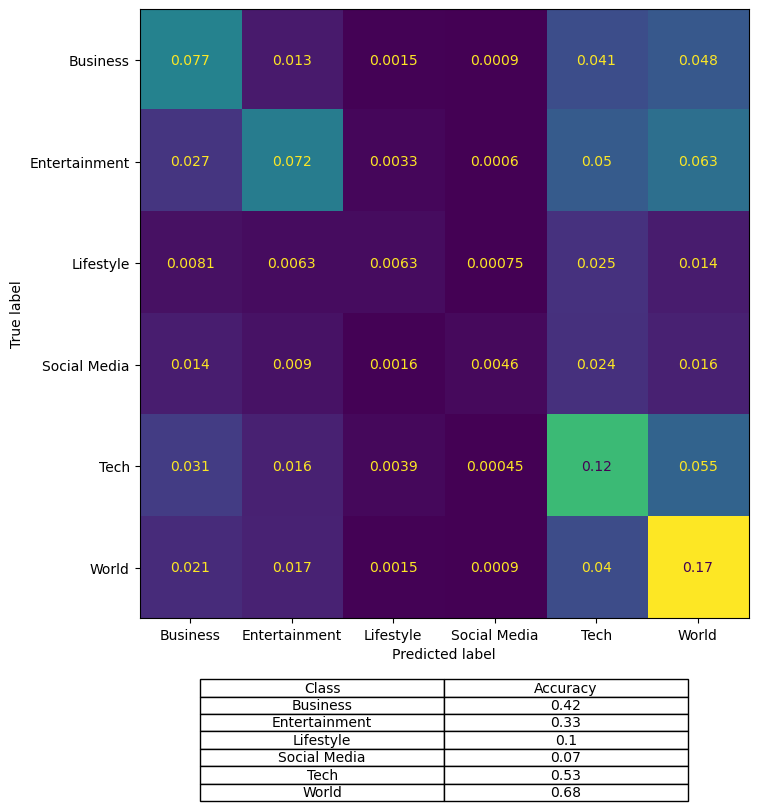

In [31]:
# param_grid = {
#     "n_neighbors": np.arange(10, 25, 5),
#     "weights": ["uniform", "distance"],
#     "p": [1, 2],
#     "n_jobs": [-1],
# }
# grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=12, n_jobs=-1)
# grid.fit(X, y)
# print(grid.best_params_)
# fit_and_score(KNeighborsClassifier(**grid.best_params_))
best_params = {
        'n_jobs': -1, 
        'n_neighbors': 20,
        'p': 1,
        'weights': 'distance'
}
fit_and_score(KNeighborsClassifier(**best_params))

### Decision Tree

{'class_weight': 'balanced', 'criterion': 'log_loss'}
               precision    recall  f1-score   support

     Business       0.51      0.53      0.52      1210
Entertainment       0.51      0.49      0.50      1442
    Lifestyle       0.26      0.27      0.27       402
 Social Media       0.34      0.33      0.33       462
         Tech       0.48      0.49      0.48      1495
        World       0.58      0.57      0.57      1691

     accuracy                           0.49      6702
    macro avg       0.45      0.45      0.45      6702
 weighted avg       0.49      0.49      0.49      6702



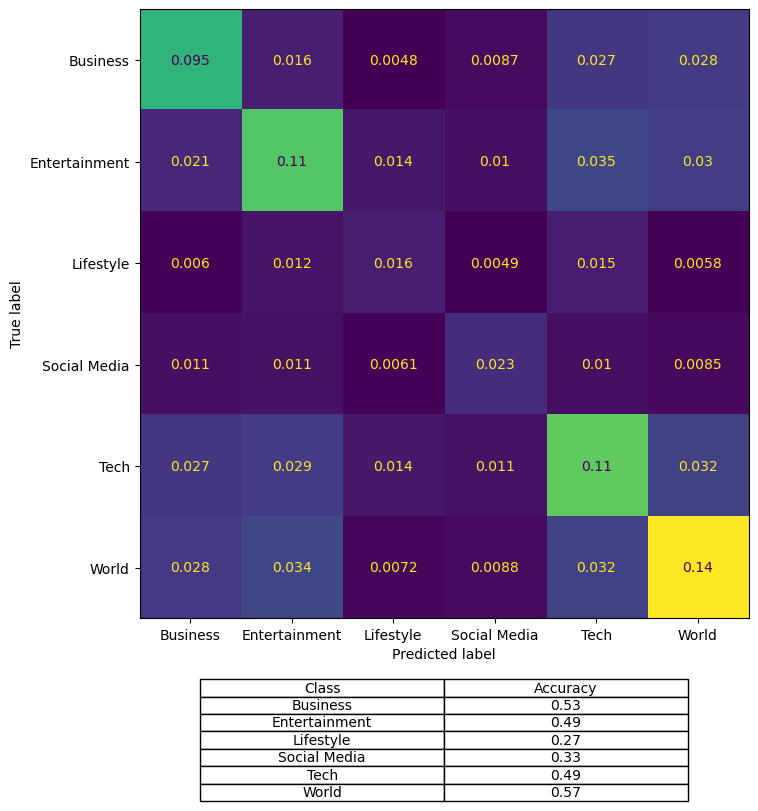

In [72]:
param_grid = {
    "criterion" : ["gini", "entropy", "log_loss"],
    "class_weight" : [None, "balanced"],
}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring="balanced_accuracy", cv=12, n_jobs=-1)
grid.fit(X, y)
print(grid.best_params_)
dtc = DecisionTreeClassifier(**grid.best_params_)
fit_and_score(dtc)

### SVM linear

/usr/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'C': np.int64(20), 'cache_size': 10000, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'kernel': 'linear'}
               precision    recall  f1-score   support

     Business       0.50      0.56      0.53      1210
Entertainment       0.62      0.45      0.52      1442
    Lifestyle       0.25      0.59      0.36       402
 Social Media       0.26      0.37      0.30       462
         Tech       0.57      0.45      0.51      1495
        World       0.68      0.61      0.65      1691

     accuracy                           0.52      6702
    macro avg       0.48      0.51      0.48      6702
 weighted avg       0.56      0.52      0.53      6702



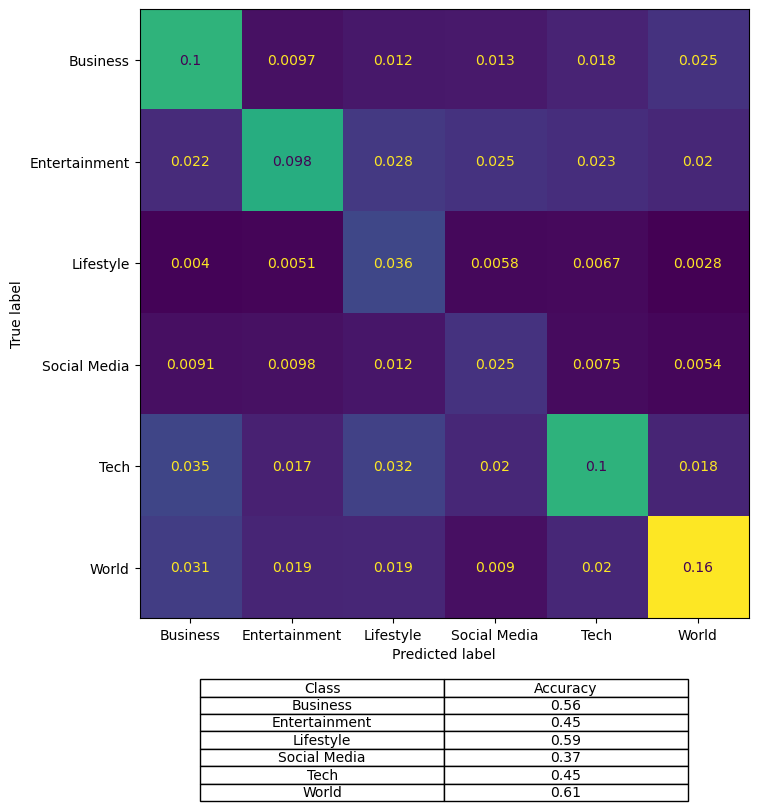

In [73]:
# {'C': 20, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'kernel': 'linear'}
param_grid = {
    "C": np.arange(10, 25, 5),
    "kernel": ["linear"],
    "class_weight": [None, "balanced"],
    "decision_function_shape": ["ovo", "ovr"],
    "cache_size": [10_000],
}
grid = GridSearchCV(SVC(), param_grid, cv=12, n_jobs=-1, scoring="balanced_accuracy")
grid.fit(X, y)
print(grid.best_params_)
fit_and_score(SVC(**grid.best_params_))

### SVM poly

{'C': 20, 'cache_size': 10000, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'degree': np.int64(2), 'gamma': 0.1, 'kernel': 'poly'}
               precision    recall  f1-score   support

     Business       0.50      0.60      0.54      1210
Entertainment       0.64      0.48      0.55      1442
    Lifestyle       0.25      0.57      0.35       402
 Social Media       0.30      0.39      0.34       462
         Tech       0.57      0.45      0.50      1495
        World       0.69      0.61      0.65      1691

     accuracy                           0.53      6702
    macro avg       0.49      0.52      0.49      6702
 weighted avg       0.57      0.53      0.54      6702



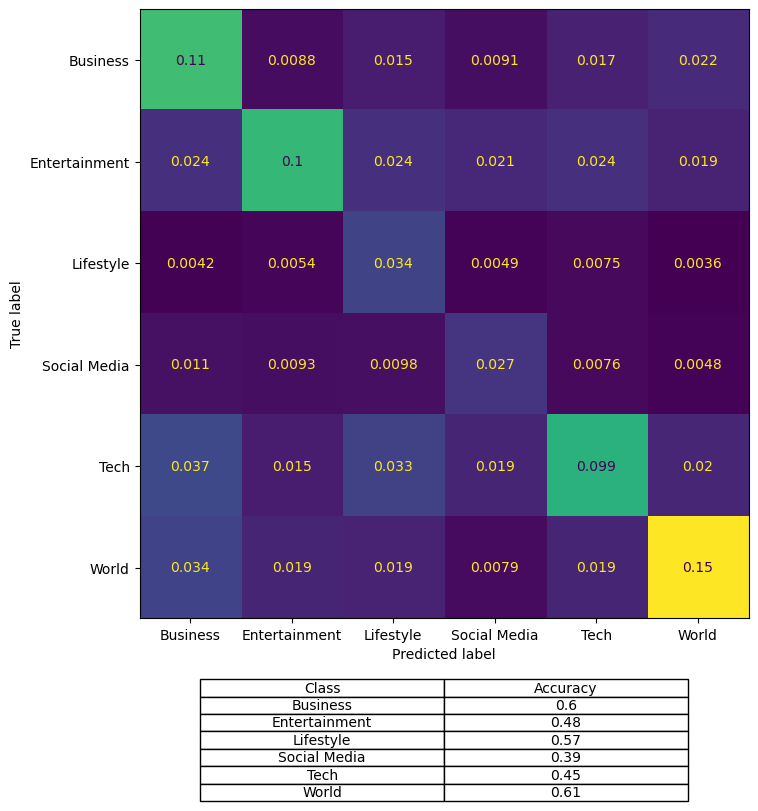

In [74]:
# {'C': 20, 'cache_size': 10000, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'degree': np.int64(2), 'gamma': 0.1, 'kernel': 'poly'}
param_grid = {
    "C": [1, 10, 20],
    "kernel": ["poly"],
    "degree": np.arange(2, 5, 1),
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
    "class_weight": ["balanced"],
    "decision_function_shape": ["ovo"],
    "cache_size": [10_000],
}
grid = GridSearchCV(SVC(), param_grid, cv=3, n_jobs=-1, scoring="balanced_accuracy")
grid.fit(X, y)
print(grid.best_params_)
fit_and_score(SVC(**grid.best_params_))

### SVM rbf

/usr/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'C': 20, 'cache_size': 10000, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
               precision    recall  f1-score   support

     Business       0.50      0.62      0.55      1210
Entertainment       0.64      0.50      0.56      1442
    Lifestyle       0.26      0.57      0.36       402
 Social Media       0.32      0.40      0.36       462
         Tech       0.57      0.45      0.50      1495
        World       0.72      0.62      0.66      1691

     accuracy                           0.54      6702
    macro avg       0.50      0.53      0.50      6702
 weighted avg       0.57      0.54      0.55      6702



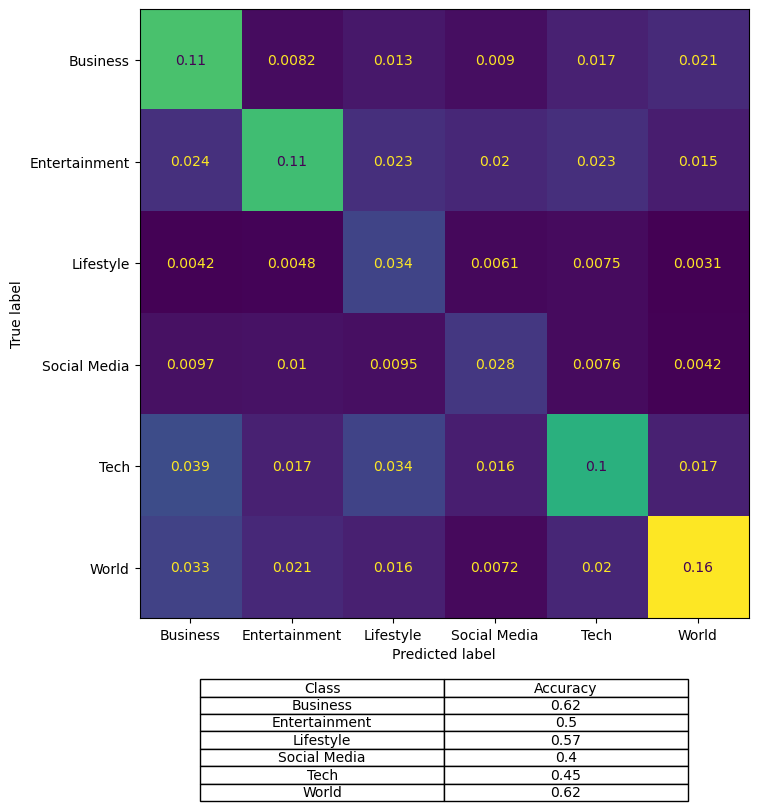

In [76]:
param_grid = {
    "C": [1, 10, 20],
    "kernel": ["poly"],
    "degree": [2, 3, 6],
    "gamma": ["scale", "auto", 0.1, 1],
    "class_weight": ["balanced"],
    "decision_function_shape": ["ovo"],
    "cache_size": [10_000],
}
grid = GridSearchCV(SVC(), param_grid, cv=4, n_jobs=-1, scoring="balanced_accuracy")
grid.fit(X, y)
print(grid.best_params_)
fit_and_score(SVC(**grid.best_params_))

### Random Forest

/usr/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 250}
               precision    recall  f1-score   support

     Business       0.67      0.65      0.66      1210
Entertainment       0.65      0.71      0.68      1442
    Lifestyle       0.58      0.24      0.34       402
 Social Media       0.71      0.34      0.46       462
         Tech       0.59      0.69      0.64      1495
        World       0.70      0.75      0.72      1691

     accuracy                           0.65      6702
    macro avg       0.65      0.56      0.58      6702
 weighted avg       0.65      0.65      0.64      6702



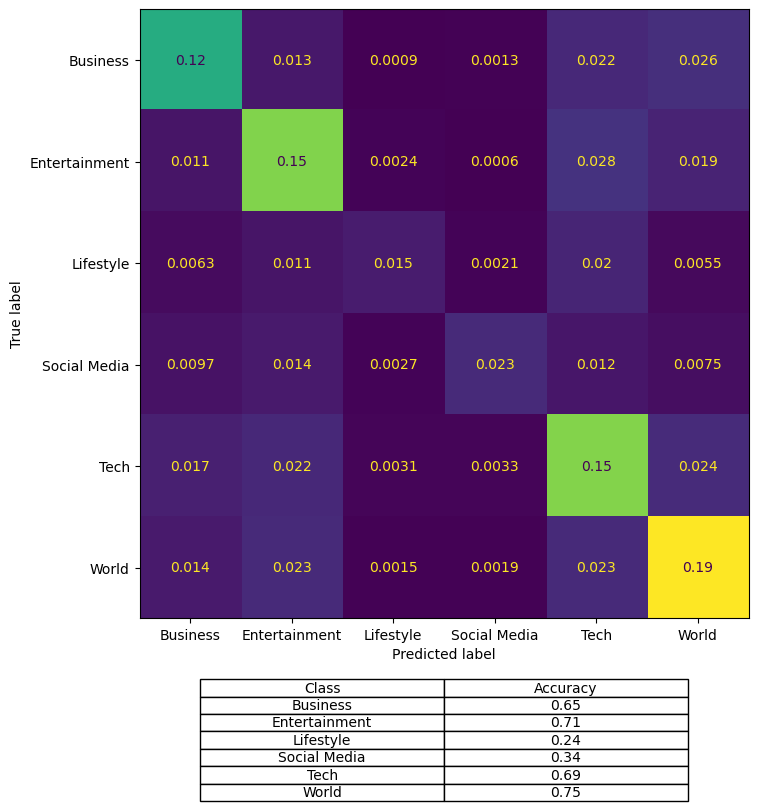

In [77]:
param_grid = {
    "n_estimators": [10, 100, 250, 300],
    "criterion" : ["gini", "entropy", "log_loss"],
    "class_weight" : ["balanced"],
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=4, n_jobs=-1)
grid.fit(X, y)
print(grid.best_params_)
fit_and_score(RandomForestClassifier(**grid.best_params_))

### AdaBoost

{'algorithm': 'SAMME', 'learning_rate': np.int64(1), 'n_estimators': 300}
               precision    recall  f1-score   support

     Business       0.56      0.57      0.56      1210
Entertainment       0.55      0.59      0.57      1442
    Lifestyle       0.38      0.26      0.31       402
 Social Media       0.47      0.26      0.34       462
         Tech       0.52      0.54      0.53      1495
        World       0.62      0.68      0.65      1691

     accuracy                           0.55      6702
    macro avg       0.52      0.48      0.49      6702
 weighted avg       0.55      0.55      0.55      6702



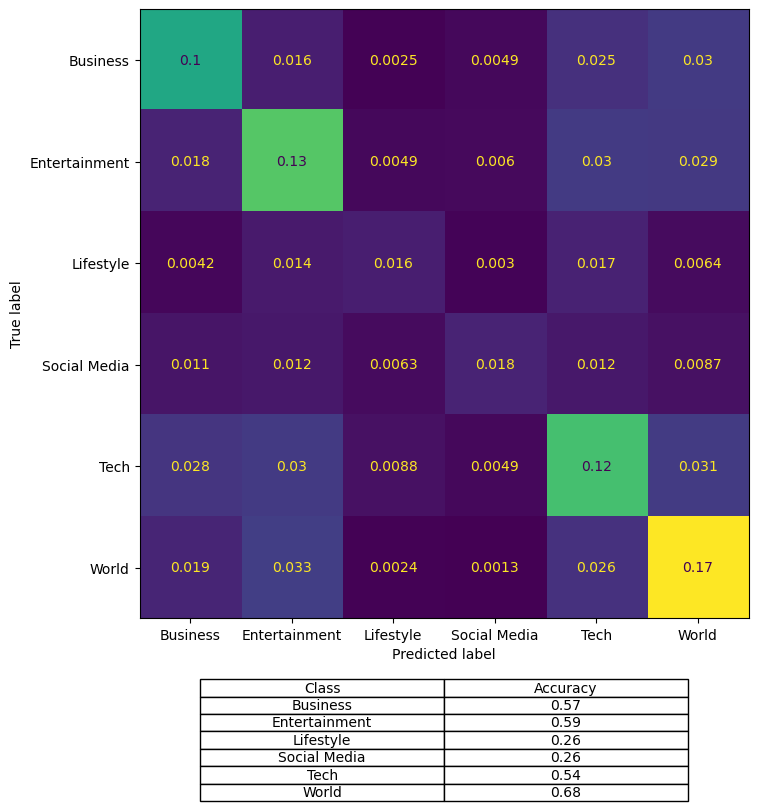

In [78]:
param_grid = {
    "n_estimators": [10, 100, 250, 300],
    "learning_rate" : np.arange(1, 10, 3),
    "algorithm" : ["SAMME"],
}
grid = GridSearchCV(AdaBoostClassifier(), param_grid, cv=12, n_jobs=-1)
grid.fit(X, y)
print(grid.best_params_)
fit_and_score(AdaBoostClassifier(**grid.best_params_))

# Conclusion
- The best mean accuracy: Random Forest(0.563)
- The worst mean accuracy: kNN(0.345)